# Deep Learning LSTM PM10 air pollution forecaster
This notebook loads the data, instantiates the LSTM model, and trains the model, then calculates the predictions.

The 'pollution_model.py' file containes the model and the functions to instantiate, train, save and run the model.

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
# ### Import resources and create data
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import pandas as pd
import pollution_model as pmod
import warnings
warnings.filterwarnings('ignore')

The data containes the daily average temperature, maximum, minimum temperature, sea level preassure, wind converted to u and v parameters, precipitation and PM10 concentration for the day. This is calculated from hourly parameters with the 'create_data.py' file.

In [2]:
# load data
df_full = pd.read_csv('daily_clean_full.csv')
df_full['datetime'] = pd.to_datetime(df_full['datetime'], format='%Y-%m-%d')
df_full.head()

,temp_avr,temp_max,temp_min,pres,u,v,prec,datetime,Budateteny,Csepel,Erzsebet,Gergely,Gilice,Honved,Kaposztas,Korakas,Kosztolanyi,Pesthidegkut,Szena,Teleki
0,-3.185714,-1.9,-4.6,1020.360691,0.963806,1.041120,0.0,2011-01-01,83.0,58.0,75.0,55.0,73.0,65.0,62.0,76.0,68.0,61.0,78.0,69.0
1,-1.212500,2.7,-4.7,1017.916448,1.500336,-0.015490,0.0,2011-01-02,37.0,29.0,35.0,24.0,36.0,28.0,21.0,35.0,32.0,25.0,33.0,35.0
2,-4.512500,-1.9,-7.7,1022.382748,-0.426777,-0.461940,0.0,2011-01-03,46.0,34.0,47.0,26.0,39.0,44.0,35.0,47.0,42.0,31.0,46.0,45.0
3,-4.462500,-3.5,-5.5,1025.815799,-0.128941,1.072592,0.0,2011-01-04,38.0,28.0,44.0,22.0,27.0,38.0,34.0,43.0,40.0,42.0,46.0,42.0
4,-4.800000,-4.3,-5.5,1025.599150,-1.841358,1.456059,0.0,2011-01-05,37.0,29.0,40.0,23.0,33.0,33.0,31.0,37.0,34.0,37.0,43.0,37.0


We use only one station for our forecast: Budapest, **Teleki** square

In [3]:
# get data for single station forecast
df = df_full[['datetime', 'temp_avr', 'temp_max', 'temp_min', 'pres', 
              'u', 'v', 'prec', 'Teleki']]
df.head()

,datetime,temp_avr,temp_max,temp_min,pres,u,v,prec,Teleki
0,2011-01-01,-3.185714,-1.9,-4.6,1020.360691,0.963806,1.041120,0.0,69.0
1,2011-01-02,-1.212500,2.7,-4.7,1017.916448,1.500336,-0.015490,0.0,35.0
2,2011-01-03,-4.512500,-1.9,-7.7,1022.382748,-0.426777,-0.461940,0.0,45.0
3,2011-01-04,-4.462500,-3.5,-5.5,1025.815799,-0.128941,1.072592,0.0,42.0
4,2011-01-05,-4.800000,-4.3,-5.5,1025.599150,-1.841358,1.456059,0.0,37.0


We need to normalize the data before training. For the air pollution columns we save the normalization parameters. Later with them we can convert the forecasted outputs to pollution concentrations.

In [4]:
# variables for later renormalization
label_mean = df['Teleki'].mean()
label_std = df['Teleki'].std()
print(f"pollution columns mean: {label_mean}")
print(f"pollution columns std: {label_std}")
#%%
# normalize columns with (c-mean)/std
df[['temp_avr','temp_max','temp_min','pres','u','v','prec','Teleki']] \
= df[['temp_avr','temp_max','temp_min','pres','u','v','prec','Teleki']] \
.apply(lambda x: (x - x.mean()) / x.std())

df.head()

pollution columns mean: 31.65729952021933
pollution columns std: 18.65859161516489


,datetime,temp_avr,temp_max,temp_min,pres,u,v,prec,Teleki
0,2011-01-01,-1.713034,-1.800535,-1.591323,0.415106,0.426107,1.128143,-0.329747,2.001368
1,2011-01-02,-1.491919,-1.349055,-1.604099,0.091325,0.756326,0.312022,-0.329747,0.179151
2,2011-01-03,-1.861712,-1.800535,-1.987373,0.682961,-0.429758,-0.032814,-0.329747,0.715097
3,2011-01-04,-1.856109,-1.957571,-1.706306,1.137725,-0.246448,1.152451,-0.329747,0.554313
4,2011-01-05,-1.893929,-2.036089,-1.706306,1.109027,-1.300392,1.448640,-0.329747,0.286340


We convert the day of week and year of week to coordinates on a one radius circel. This way the days closer to each other will have similar coordinates. We hope that this helps the model to understand some periodic behavior of the dataset.

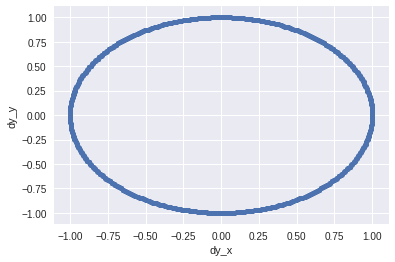

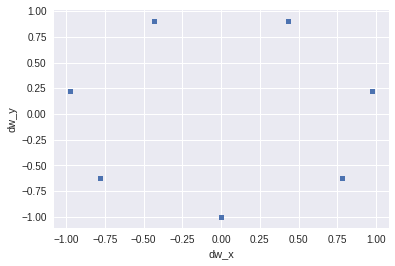

In [5]:
# Convert day of year and day of week numbers to coordinates of a point
# on a circle. This way day of year and day of week will become periodic 
# data
# first convert days to scale
df['day_week'] = df['datetime'].dt.dayofweek*(360/7)
df['day_year'] = df['datetime'].dt.dayofyear*(360/365)
# then convert scales to coordinates on 1 radius circle
# rad = 4.0*atan(1.0)/180
df['dw_x'] = -np.sin((4.0*np.arctan(1.0)/180)*df['day_week'])
df['dw_y'] = -np.cos((4.0*np.arctan(1.0)/180)*df['day_week'])
df['dy_x'] = -np.sin((4.0*np.arctan(1.0)/180)*df['day_year'])
df['dy_y'] = -np.cos((4.0*np.arctan(1.0)/180)*df['day_year'])

df.plot.scatter(x='dy_x', y='dy_y')
df.plot.scatter(x='dw_x', y='dw_y')

In real situation for a given day we know the weather (from a weather forecast, which here is represented by the weather station data) and the airpollution a day before (Teleki_ystd). So we add to a row of parameters the airpollution of the prior day. The air pollution of the given day (Teleki) will be our label. We want our forecast as close to this label as possible.

In [6]:
# make the yesterday day column
df['Teleki_ystd'] = df['Teleki'].shift(+1)
# fill the missing day value with next day
df['Teleki_ystd'] = df['Teleki_ystd'].fillna(method='bfill')
# reorder columns, last column will be the label data
df = df[['datetime','dy_x','dy_y','dw_x','dw_y',
         'temp_avr','temp_max','temp_min','pres', 
         'u','v','prec','Teleki_ystd','Teleki']]
df.head()

,datetime,dy_x,dy_y,dw_x,dw_y,temp_avr,temp_max,temp_min,pres,u,v,prec,Teleki_ystd,Teleki
0,2011-01-01,-0.017213,-0.999852,0.974928,0.222521,-1.713034,-1.800535,-1.591323,0.415106,0.426107,1.128143,-0.329747,2.001368,2.001368
1,2011-01-02,-0.034422,-0.999407,0.781831,-0.623490,-1.491919,-1.349055,-1.604099,0.091325,0.756326,0.312022,-0.329747,2.001368,0.179151
2,2011-01-03,-0.051620,-0.998667,-0.000000,-1.000000,-1.861712,-1.800535,-1.987373,0.682961,-0.429758,-0.032814,-0.329747,0.179151,0.715097
3,2011-01-04,-0.068802,-0.997630,-0.781831,-0.623490,-1.856109,-1.957571,-1.706306,1.137725,-0.246448,1.152451,-0.329747,0.715097,0.554313
4,2011-01-05,-0.085965,-0.996298,-0.974928,0.222521,-1.893929,-2.036089,-1.706306,1.109027,-1.300392,1.448640,-0.329747,0.554313,0.286340


Split the database to train, validation and test data.

In [7]:
# build the pytorch train, validation and test sets
# train data
mask = (df['datetime'] < '2017-01-01')
df_train = df.loc[mask].drop(columns=['datetime'])
# train tensors
train_data = torch.tensor(df_train.values).float()
print(train_data.shape)

# validation data
mask = (df['datetime'] < '2018-01-01') & (df['datetime'] >= '2017-01-01')
df_valid = df.loc[mask].drop(columns=['datetime'])
# validation tensors
valid_data = torch.tensor(df_valid.values).float()
print(valid_data.shape)

# test data
mask = (df['datetime'] >= '2018-01-01')
df_test = df.loc[mask].drop(columns=['datetime'])
# validation tensors
test_data = torch.tensor(df_test.values).float()
print(test_data.shape)

torch.Size([2192, 13])
torch.Size([365, 13])
torch.Size([361, 13])


In [8]:
# check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


Here we instantiate our model.

In [9]:
# define and print the net
number_of_features = train_data.shape[1] - 1 # -1 because last column is label
n_hidden=256
n_layers=3
net = pmod.instantiate_model(number_of_features, 1, n_hidden, n_layers, train_on_gpu)
print(net)

LSTMForecaster(
  (lstm): LSTM(12, 256, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=256, out_features=1, bias=True)
)


We train our model. During training the step with the smallest validation loss will be saved. Later we will load back the modell with the smallest loss.

model saved with 0.9113655611872673 mean_val_loss
Epoch: 1/100... Step: 4 train_loss: 0.5541... mean_val_loss: 0.9114
model saved with 0.8637038953602314 mean_val_loss
Epoch: 1/100... Step: 8 train_loss: 1.5459... mean_val_loss: 0.8637
model saved with 0.8214590984086195 mean_val_loss
Epoch: 1/100... Step: 12 train_loss: 0.7616... mean_val_loss: 0.8215
model saved with 0.788807200267911 mean_val_loss
Epoch: 2/100... Step: 16 train_loss: 0.6802... mean_val_loss: 0.7888


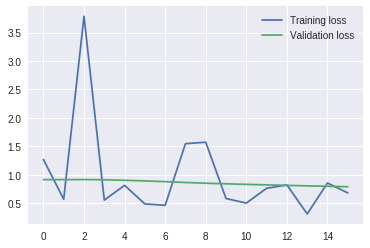

model saved with 0.7775026768445968 mean_val_loss
Epoch: 2/100... Step: 20 train_loss: 0.3597... mean_val_loss: 0.7775
model saved with 0.7702540655930837 mean_val_loss
Epoch: 2/100... Step: 24 train_loss: 0.4065... mean_val_loss: 0.7703
model saved with 0.758631840880428 mean_val_loss
Epoch: 2/100... Step: 28 train_loss: 0.2406... mean_val_loss: 0.7586
model saved with 0.7438239543698728 mean_val_loss
Epoch: 3/100... Step: 32 train_loss: 0.3302... mean_val_loss: 0.7438


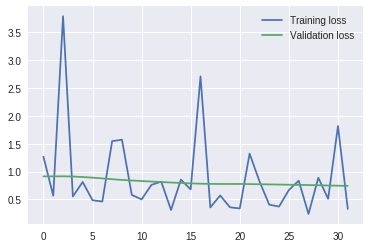

model saved with 0.7369561158120632 mean_val_loss
Epoch: 3/100... Step: 36 train_loss: 1.0626... mean_val_loss: 0.7370
model saved with 0.7162571310997009 mean_val_loss
Epoch: 3/100... Step: 40 train_loss: 0.6133... mean_val_loss: 0.7163
model saved with 0.6951505277644504 mean_val_loss
Epoch: 4/100... Step: 44 train_loss: 0.4448... mean_val_loss: 0.6952
model saved with 0.6757381015146772 mean_val_loss
Epoch: 4/100... Step: 48 train_loss: 0.2482... mean_val_loss: 0.6757


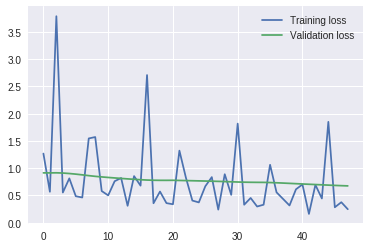

model saved with 0.6660329249615853 mean_val_loss
Epoch: 4/100... Step: 52 train_loss: 0.4451... mean_val_loss: 0.6660
model saved with 0.6498938198866588 mean_val_loss
Epoch: 4/100... Step: 56 train_loss: 0.1083... mean_val_loss: 0.6499
model saved with 0.6320235141863425 mean_val_loss
Epoch: 5/100... Step: 60 train_loss: 0.2475... mean_val_loss: 0.6320
model saved with 0.6158151552081108 mean_val_loss
Epoch: 5/100... Step: 64 train_loss: 0.7694... mean_val_loss: 0.6158


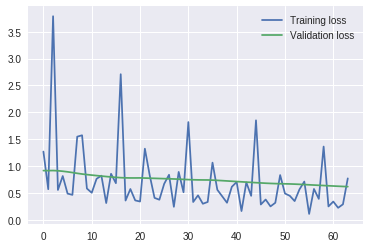

model saved with 0.604549652294201 mean_val_loss
Epoch: 5/100... Step: 68 train_loss: 0.4657... mean_val_loss: 0.6045
model saved with 0.590228607878089 mean_val_loss
Epoch: 6/100... Step: 72 train_loss: 0.3485... mean_val_loss: 0.5902
model saved with 0.5747312185795683 mean_val_loss
Epoch: 6/100... Step: 76 train_loss: 0.2051... mean_val_loss: 0.5747
model saved with 0.5599939791485667 mean_val_loss
Epoch: 6/100... Step: 80 train_loss: 0.2287... mean_val_loss: 0.5600


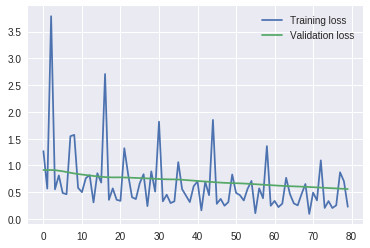

model saved with 0.5471621110503163 mean_val_loss
Epoch: 6/100... Step: 84 train_loss: 0.0956... mean_val_loss: 0.5472
model saved with 0.535570320927284 mean_val_loss
Epoch: 7/100... Step: 88 train_loss: 0.1790... mean_val_loss: 0.5356
model saved with 0.5242715812409702 mean_val_loss
Epoch: 7/100... Step: 92 train_loss: 0.6227... mean_val_loss: 0.5243
model saved with 0.5131358160482099 mean_val_loss
Epoch: 7/100... Step: 96 train_loss: 0.3005... mean_val_loss: 0.5131


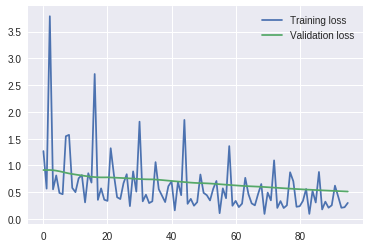

model saved with 0.5026912267506123 mean_val_loss
Epoch: 8/100... Step: 100 train_loss: 0.2980... mean_val_loss: 0.5027
model saved with 0.494337137000492 mean_val_loss
Epoch: 8/100... Step: 104 train_loss: 0.2054... mean_val_loss: 0.4943
model saved with 0.4884254617133626 mean_val_loss
Epoch: 8/100... Step: 108 train_loss: 0.2618... mean_val_loss: 0.4884
model saved with 0.4801119586585888 mean_val_loss
Epoch: 8/100... Step: 112 train_loss: 0.0894... mean_val_loss: 0.4801


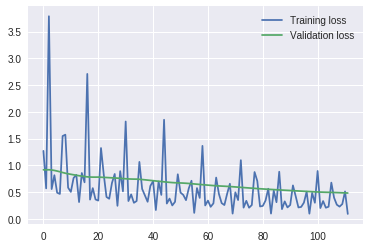

model saved with 0.4722353720973278 mean_val_loss
Epoch: 9/100... Step: 116 train_loss: 0.1829... mean_val_loss: 0.4722
model saved with 0.4655947716285785 mean_val_loss
Epoch: 9/100... Step: 120 train_loss: 0.6824... mean_val_loss: 0.4656
model saved with 0.4608081954140817 mean_val_loss
Epoch: 9/100... Step: 124 train_loss: 0.2747... mean_val_loss: 0.4608
model saved with 0.4546116985147819 mean_val_loss
Epoch: 10/100... Step: 128 train_loss: 0.3221... mean_val_loss: 0.4546


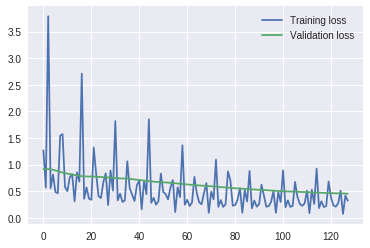

model saved with 0.44807883436706936 mean_val_loss
Epoch: 10/100... Step: 132 train_loss: 0.1860... mean_val_loss: 0.4481
model saved with 0.4419632371076766 mean_val_loss
Epoch: 10/100... Step: 136 train_loss: 0.1653... mean_val_loss: 0.4420
model saved with 0.43740420671445984 mean_val_loss
Epoch: 10/100... Step: 140 train_loss: 0.0756... mean_val_loss: 0.4374
model saved with 0.43212032768254477 mean_val_loss
Epoch: 11/100... Step: 144 train_loss: 0.1883... mean_val_loss: 0.4321


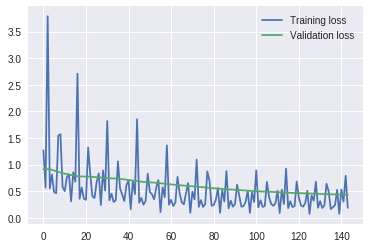

model saved with 0.4268870270634825 mean_val_loss
Epoch: 11/100... Step: 148 train_loss: 0.6841... mean_val_loss: 0.4269
model saved with 0.4217856364128621 mean_val_loss
Epoch: 11/100... Step: 152 train_loss: 0.2492... mean_val_loss: 0.4218
model saved with 0.4172033734428577 mean_val_loss
Epoch: 12/100... Step: 156 train_loss: 0.2934... mean_val_loss: 0.4172
model saved with 0.41322561642155053 mean_val_loss
Epoch: 12/100... Step: 160 train_loss: 0.1860... mean_val_loss: 0.4132


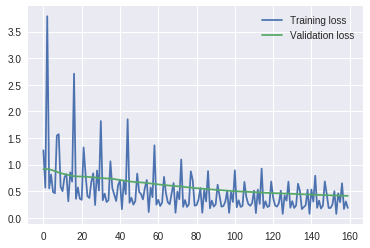

model saved with 0.4091278404088282 mean_val_loss
Epoch: 12/100... Step: 164 train_loss: 0.2050... mean_val_loss: 0.4091
model saved with 0.4049312144163109 mean_val_loss
Epoch: 12/100... Step: 168 train_loss: 0.1080... mean_val_loss: 0.4049
model saved with 0.4008089553044979 mean_val_loss
Epoch: 13/100... Step: 172 train_loss: 0.1832... mean_val_loss: 0.4008
model saved with 0.3979591505009342 mean_val_loss
Epoch: 13/100... Step: 176 train_loss: 0.5468... mean_val_loss: 0.3980


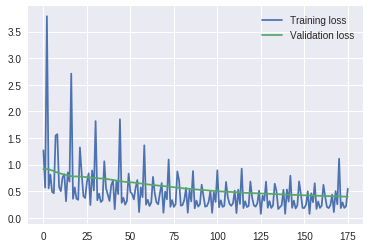

model saved with 0.3971160169276926 mean_val_loss
Epoch: 13/100... Step: 180 train_loss: 0.2644... mean_val_loss: 0.3971
model saved with 0.39421653314291133 mean_val_loss
Epoch: 14/100... Step: 184 train_loss: 0.2659... mean_val_loss: 0.3942
model saved with 0.3912711705457657 mean_val_loss
Epoch: 14/100... Step: 188 train_loss: 0.1778... mean_val_loss: 0.3913
model saved with 0.38833327296500403 mean_val_loss
Epoch: 14/100... Step: 192 train_loss: 0.1777... mean_val_loss: 0.3883


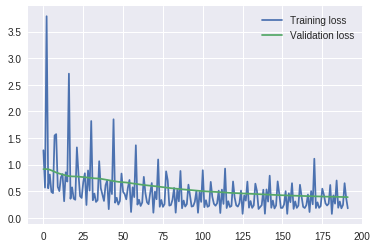

model saved with 0.38555609659120743 mean_val_loss
Epoch: 14/100... Step: 196 train_loss: 0.0731... mean_val_loss: 0.3856
model saved with 0.38279473334550856 mean_val_loss
Epoch: 15/100... Step: 200 train_loss: 0.1649... mean_val_loss: 0.3828
model saved with 0.37965605849874956 mean_val_loss
Epoch: 15/100... Step: 204 train_loss: 0.6047... mean_val_loss: 0.3797
model saved with 0.3766218555661348 mean_val_loss
Epoch: 15/100... Step: 208 train_loss: 0.1963... mean_val_loss: 0.3766


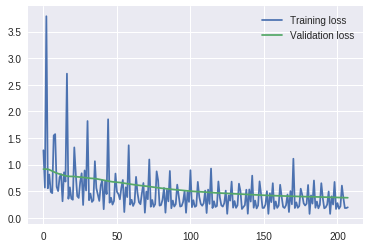

model saved with 0.3737392135948505 mean_val_loss
Epoch: 16/100... Step: 212 train_loss: 0.2629... mean_val_loss: 0.3737
model saved with 0.3711309852423491 mean_val_loss
Epoch: 16/100... Step: 216 train_loss: 0.1883... mean_val_loss: 0.3711
model saved with 0.36865609296682206 mean_val_loss
Epoch: 16/100... Step: 220 train_loss: 0.2122... mean_val_loss: 0.3687
model saved with 0.36599529562850613 mean_val_loss
Epoch: 16/100... Step: 224 train_loss: 0.0748... mean_val_loss: 0.3660


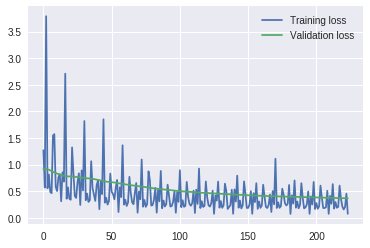

model saved with 0.36342675732285307 mean_val_loss
Epoch: 17/100... Step: 228 train_loss: 0.1806... mean_val_loss: 0.3634
model saved with 0.3615869371830646 mean_val_loss
Epoch: 17/100... Step: 232 train_loss: 0.6515... mean_val_loss: 0.3616
model saved with 0.36043487272967223 mean_val_loss
Epoch: 17/100... Step: 236 train_loss: 0.2148... mean_val_loss: 0.3604
model saved with 0.3585641685407609 mean_val_loss
Epoch: 18/100... Step: 240 train_loss: 0.2698... mean_val_loss: 0.3586


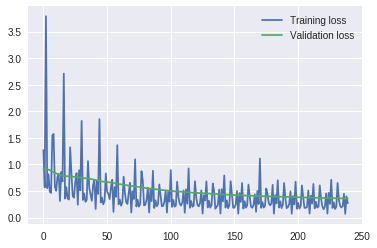

model saved with 0.35644591124881 mean_val_loss
Epoch: 18/100... Step: 244 train_loss: 0.1693... mean_val_loss: 0.3564
model saved with 0.3543208128352079 mean_val_loss
Epoch: 18/100... Step: 248 train_loss: 0.1441... mean_val_loss: 0.3543
model saved with 0.3522668344722617 mean_val_loss
Epoch: 18/100... Step: 252 train_loss: 0.0700... mean_val_loss: 0.3523
model saved with 0.3504888613097137 mean_val_loss
Epoch: 19/100... Step: 256 train_loss: 0.1636... mean_val_loss: 0.3505


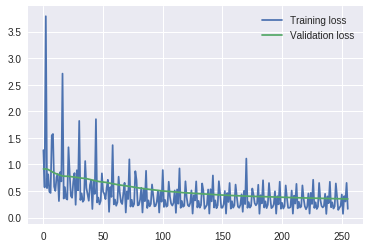

model saved with 0.3486808415215749 mean_val_loss
Epoch: 19/100... Step: 260 train_loss: 0.5413... mean_val_loss: 0.3487
model saved with 0.34667361897388194 mean_val_loss
Epoch: 19/100... Step: 264 train_loss: 0.1806... mean_val_loss: 0.3467
model saved with 0.34465897190315065 mean_val_loss
Epoch: 20/100... Step: 268 train_loss: 0.2483... mean_val_loss: 0.3447
model saved with 0.34303206419024396 mean_val_loss
Epoch: 20/100... Step: 272 train_loss: 0.1645... mean_val_loss: 0.3430


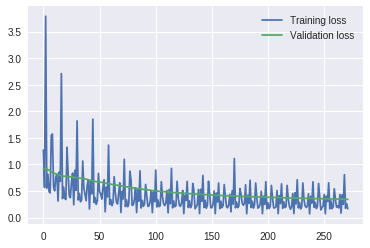

model saved with 0.3421749208203476 mean_val_loss
Epoch: 20/100... Step: 276 train_loss: 0.2187... mean_val_loss: 0.3422
model saved with 0.34067600498508127 mean_val_loss
Epoch: 20/100... Step: 280 train_loss: 0.0884... mean_val_loss: 0.3407
model saved with 0.3390140773098863 mean_val_loss
Epoch: 21/100... Step: 284 train_loss: 0.1775... mean_val_loss: 0.3390
model saved with 0.33756467323595035 mean_val_loss
Epoch: 21/100... Step: 288 train_loss: 0.6200... mean_val_loss: 0.3376


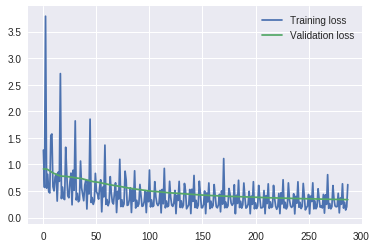

model saved with 0.3364926463962622 mean_val_loss
Epoch: 21/100... Step: 292 train_loss: 0.2032... mean_val_loss: 0.3365
model saved with 0.3352943032199668 mean_val_loss
Epoch: 22/100... Step: 296 train_loss: 0.2606... mean_val_loss: 0.3353
model saved with 0.33371075286219515 mean_val_loss
Epoch: 22/100... Step: 300 train_loss: 0.1626... mean_val_loss: 0.3337
model saved with 0.33218741822546644 mean_val_loss
Epoch: 22/100... Step: 304 train_loss: 0.1651... mean_val_loss: 0.3322


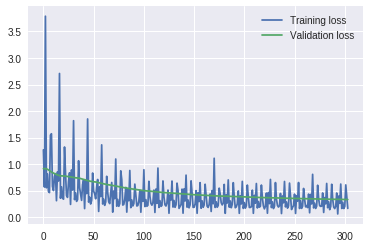

model saved with 0.33070976235117616 mean_val_loss
Epoch: 22/100... Step: 308 train_loss: 0.0691... mean_val_loss: 0.3307
model saved with 0.3294117789452848 mean_val_loss
Epoch: 23/100... Step: 312 train_loss: 0.1834... mean_val_loss: 0.3294
model saved with 0.3284993463231227 mean_val_loss
Epoch: 23/100... Step: 316 train_loss: 0.6197... mean_val_loss: 0.3285
model saved with 0.32706730916397647 mean_val_loss
Epoch: 23/100... Step: 320 train_loss: 0.1991... mean_val_loss: 0.3271


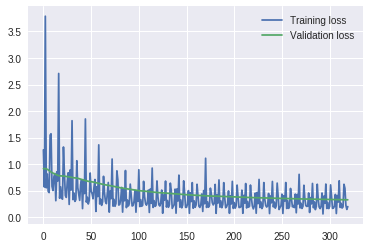

model saved with 0.325984898828154 mean_val_loss
Epoch: 24/100... Step: 324 train_loss: 0.2497... mean_val_loss: 0.3260
model saved with 0.324690206896332 mean_val_loss
Epoch: 24/100... Step: 328 train_loss: 0.1488... mean_val_loss: 0.3247
model saved with 0.32458205003829965 mean_val_loss
Epoch: 24/100... Step: 332 train_loss: 0.2833... mean_val_loss: 0.3246
model saved with 0.3242785294118914 mean_val_loss
Epoch: 24/100... Step: 336 train_loss: 0.0634... mean_val_loss: 0.3243


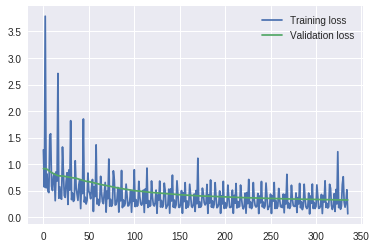

model saved with 0.3232507475268315 mean_val_loss
Epoch: 25/100... Step: 340 train_loss: 0.1819... mean_val_loss: 0.3233
model saved with 0.3221947720469257 mean_val_loss
Epoch: 25/100... Step: 344 train_loss: 0.5843... mean_val_loss: 0.3222
model saved with 0.32127355342067176 mean_val_loss
Epoch: 25/100... Step: 348 train_loss: 0.1915... mean_val_loss: 0.3213
model saved with 0.3204424051800743 mean_val_loss
Epoch: 26/100... Step: 352 train_loss: 0.2899... mean_val_loss: 0.3204


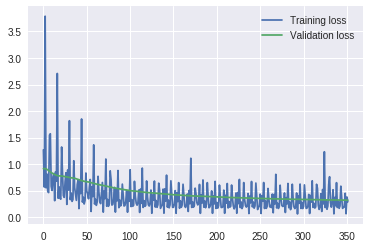

model saved with 0.3192848355268662 mean_val_loss
Epoch: 26/100... Step: 356 train_loss: 0.1426... mean_val_loss: 0.3193
model saved with 0.3180275200348761 mean_val_loss
Epoch: 26/100... Step: 360 train_loss: 0.1871... mean_val_loss: 0.3180
model saved with 0.3168386123603681 mean_val_loss
Epoch: 26/100... Step: 364 train_loss: 0.0687... mean_val_loss: 0.3168
model saved with 0.3157582636821367 mean_val_loss
Epoch: 27/100... Step: 368 train_loss: 0.1799... mean_val_loss: 0.3158


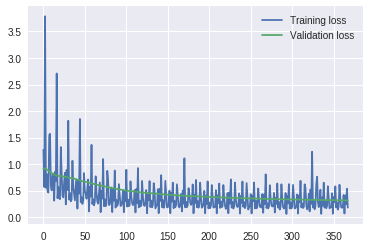

model saved with 0.3148261992140643 mean_val_loss
Epoch: 27/100... Step: 372 train_loss: 0.5565... mean_val_loss: 0.3148
model saved with 0.3137489964075862 mean_val_loss
Epoch: 27/100... Step: 376 train_loss: 0.1689... mean_val_loss: 0.3137
model saved with 0.3125949359351867 mean_val_loss
Epoch: 28/100... Step: 380 train_loss: 0.2319... mean_val_loss: 0.3126
model saved with 0.3116102735705984 mean_val_loss
Epoch: 28/100... Step: 384 train_loss: 0.1520... mean_val_loss: 0.3116


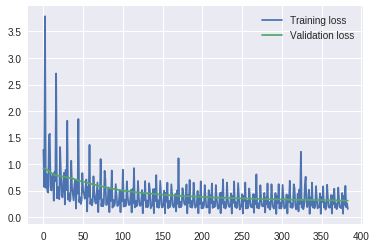

model saved with 0.3110620900604528 mean_val_loss
Epoch: 28/100... Step: 388 train_loss: 0.2013... mean_val_loss: 0.3111
model saved with 0.310468509774275 mean_val_loss
Epoch: 28/100... Step: 392 train_loss: 0.0732... mean_val_loss: 0.3105
model saved with 0.3095668936806797 mean_val_loss
Epoch: 29/100... Step: 396 train_loss: 0.1668... mean_val_loss: 0.3096
model saved with 0.30866276612505317 mean_val_loss
Epoch: 29/100... Step: 400 train_loss: 0.5596... mean_val_loss: 0.3087


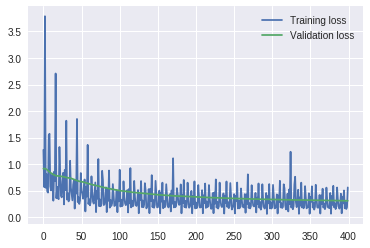

model saved with 0.30795897217006374 mean_val_loss
Epoch: 29/100... Step: 404 train_loss: 0.1808... mean_val_loss: 0.3080
model saved with 0.30728027200801117 mean_val_loss
Epoch: 30/100... Step: 408 train_loss: 0.2684... mean_val_loss: 0.3073
model saved with 0.30635846144004353 mean_val_loss
Epoch: 30/100... Step: 412 train_loss: 0.1604... mean_val_loss: 0.3064
model saved with 0.3053576680921161 mean_val_loss
Epoch: 30/100... Step: 416 train_loss: 0.1728... mean_val_loss: 0.3054


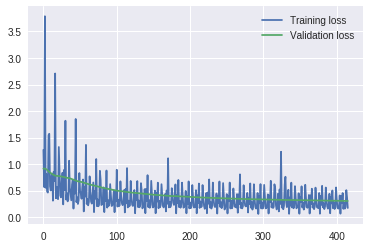

model saved with 0.30441606878524735 mean_val_loss
Epoch: 30/100... Step: 420 train_loss: 0.0759... mean_val_loss: 0.3044
model saved with 0.3035218311157429 mean_val_loss
Epoch: 31/100... Step: 424 train_loss: 0.1611... mean_val_loss: 0.3035
model saved with 0.3028111862732428 mean_val_loss
Epoch: 31/100... Step: 428 train_loss: 0.5331... mean_val_loss: 0.3028
model saved with 0.30198776395991445 mean_val_loss
Epoch: 31/100... Step: 432 train_loss: 0.1514... mean_val_loss: 0.3020


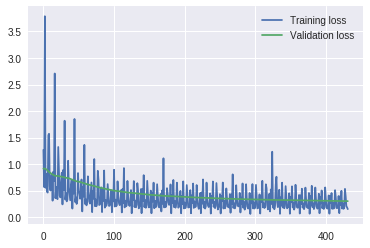

model saved with 0.30107014410095206 mean_val_loss
Epoch: 32/100... Step: 436 train_loss: 0.2219... mean_val_loss: 0.3011
model saved with 0.30022093044085935 mean_val_loss
Epoch: 32/100... Step: 440 train_loss: 0.1415... mean_val_loss: 0.3002
model saved with 0.2996164903732705 mean_val_loss
Epoch: 32/100... Step: 444 train_loss: 0.2135... mean_val_loss: 0.2996
model saved with 0.2990625406133144 mean_val_loss
Epoch: 32/100... Step: 448 train_loss: 0.0681... mean_val_loss: 0.2991


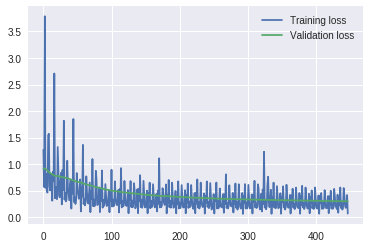

model saved with 0.29830975575883567 mean_val_loss
Epoch: 33/100... Step: 452 train_loss: 0.1601... mean_val_loss: 0.2983
model saved with 0.2975128859510286 mean_val_loss
Epoch: 33/100... Step: 456 train_loss: 0.5522... mean_val_loss: 0.2975
model saved with 0.29675507206145835 mean_val_loss
Epoch: 33/100... Step: 460 train_loss: 0.1765... mean_val_loss: 0.2968
model saved with 0.296029115312508 mean_val_loss
Epoch: 34/100... Step: 464 train_loss: 0.2221... mean_val_loss: 0.2960


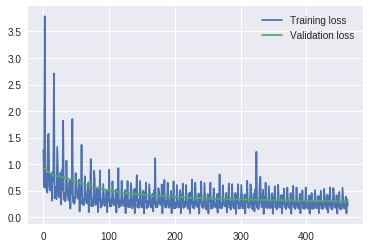

model saved with 0.2952405706398253 mean_val_loss
Epoch: 34/100... Step: 468 train_loss: 0.1463... mean_val_loss: 0.2952
model saved with 0.2944062855094671 mean_val_loss
Epoch: 34/100... Step: 472 train_loss: 0.1852... mean_val_loss: 0.2944
model saved with 0.29356265964158695 mean_val_loss
Epoch: 34/100... Step: 476 train_loss: 0.0701... mean_val_loss: 0.2936
model saved with 0.29277260358600565 mean_val_loss
Epoch: 35/100... Step: 480 train_loss: 0.1554... mean_val_loss: 0.2928


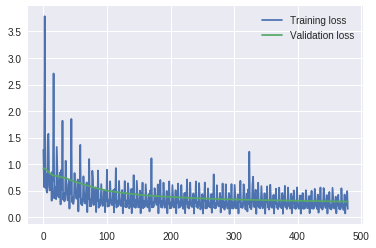

model saved with 0.29237813651099925 mean_val_loss
Epoch: 35/100... Step: 484 train_loss: 0.5175... mean_val_loss: 0.2924
model saved with 0.29191369587005894 mean_val_loss
Epoch: 35/100... Step: 488 train_loss: 0.1705... mean_val_loss: 0.2919
model saved with 0.2911816446746631 mean_val_loss
Epoch: 36/100... Step: 492 train_loss: 0.2171... mean_val_loss: 0.2912
model saved with 0.2903723934319832 mean_val_loss
Epoch: 36/100... Step: 496 train_loss: 0.1511... mean_val_loss: 0.2904


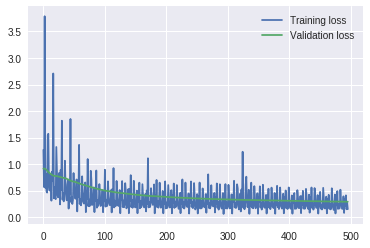

model saved with 0.28958714788407086 mean_val_loss
Epoch: 36/100... Step: 500 train_loss: 0.1931... mean_val_loss: 0.2896
model saved with 0.28897389615072855 mean_val_loss
Epoch: 36/100... Step: 504 train_loss: 0.0697... mean_val_loss: 0.2890
model saved with 0.28831828107661384 mean_val_loss
Epoch: 37/100... Step: 508 train_loss: 0.1750... mean_val_loss: 0.2883
model saved with 0.28762288800498936 mean_val_loss
Epoch: 37/100... Step: 512 train_loss: 0.5060... mean_val_loss: 0.2876


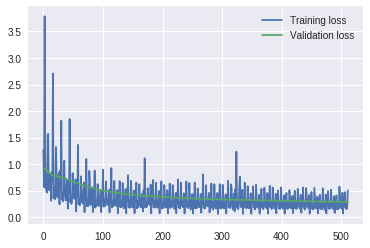

model saved with 0.2869214210442679 mean_val_loss
Epoch: 37/100... Step: 516 train_loss: 0.1721... mean_val_loss: 0.2869
model saved with 0.2862523073545442 mean_val_loss
Epoch: 38/100... Step: 520 train_loss: 0.2157... mean_val_loss: 0.2863
model saved with 0.2857744843763022 mean_val_loss
Epoch: 38/100... Step: 524 train_loss: 0.1529... mean_val_loss: 0.2858
model saved with 0.28541368278533674 mean_val_loss
Epoch: 38/100... Step: 528 train_loss: 0.2012... mean_val_loss: 0.2854


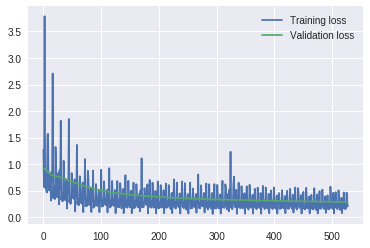

model saved with 0.28491921502312545 mean_val_loss
Epoch: 38/100... Step: 532 train_loss: 0.0637... mean_val_loss: 0.2849
model saved with 0.2843066991807254 mean_val_loss
Epoch: 39/100... Step: 536 train_loss: 0.1667... mean_val_loss: 0.2843
model saved with 0.2836938827057128 mean_val_loss
Epoch: 39/100... Step: 540 train_loss: 0.5061... mean_val_loss: 0.2837
model saved with 0.2831509432563668 mean_val_loss
Epoch: 39/100... Step: 544 train_loss: 0.1708... mean_val_loss: 0.2832


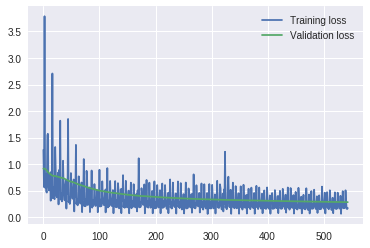

model saved with 0.2826287890682473 mean_val_loss
Epoch: 40/100... Step: 548 train_loss: 0.2008... mean_val_loss: 0.2826
model saved with 0.2820075191759869 mean_val_loss
Epoch: 40/100... Step: 552 train_loss: 0.1275... mean_val_loss: 0.2820
model saved with 0.28133599362972617 mean_val_loss
Epoch: 40/100... Step: 556 train_loss: 0.2052... mean_val_loss: 0.2813
model saved with 0.2806479566264898 mean_val_loss
Epoch: 40/100... Step: 560 train_loss: 0.0593... mean_val_loss: 0.2806


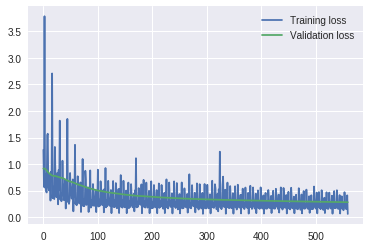

model saved with 0.28003591065235595 mean_val_loss
Epoch: 41/100... Step: 564 train_loss: 0.1482... mean_val_loss: 0.2800
model saved with 0.2797610951902371 mean_val_loss
Epoch: 41/100... Step: 568 train_loss: 0.5325... mean_val_loss: 0.2798
model saved with 0.2793211752770247 mean_val_loss
Epoch: 41/100... Step: 572 train_loss: 0.1522... mean_val_loss: 0.2793
model saved with 0.2787080149347376 mean_val_loss
Epoch: 42/100... Step: 576 train_loss: 0.1919... mean_val_loss: 0.2787


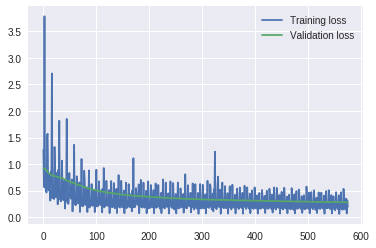

model saved with 0.2783245421303757 mean_val_loss
Epoch: 42/100... Step: 580 train_loss: 0.1551... mean_val_loss: 0.2783
Epoch: 42/100... Step: 584 train_loss: 0.2250... mean_val_loss: 0.2785
Epoch: 42/100... Step: 588 train_loss: 0.0693... mean_val_loss: 0.2789
Epoch: 43/100... Step: 592 train_loss: 0.1667... mean_val_loss: 0.2785


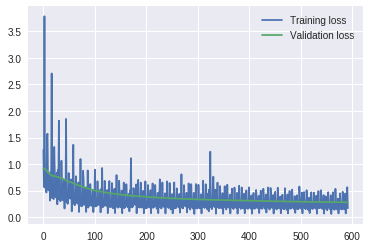

model saved with 0.2779635677189135 mean_val_loss
Epoch: 43/100... Step: 596 train_loss: 0.5632... mean_val_loss: 0.2780
model saved with 0.277471079621464 mean_val_loss
Epoch: 43/100... Step: 600 train_loss: 0.1978... mean_val_loss: 0.2775
model saved with 0.2769960263275251 mean_val_loss
Epoch: 44/100... Step: 604 train_loss: 0.2129... mean_val_loss: 0.2770
model saved with 0.27665020374115556 mean_val_loss
Epoch: 44/100... Step: 608 train_loss: 0.1437... mean_val_loss: 0.2767


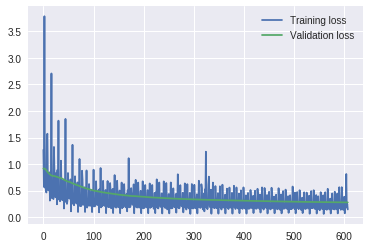

model saved with 0.276273150325698 mean_val_loss
Epoch: 44/100... Step: 612 train_loss: 0.2070... mean_val_loss: 0.2763
model saved with 0.2758248937679092 mean_val_loss
Epoch: 44/100... Step: 616 train_loss: 0.1163... mean_val_loss: 0.2758
model saved with 0.27540045167289434 mean_val_loss
Epoch: 45/100... Step: 620 train_loss: 0.1822... mean_val_loss: 0.2754
Epoch: 45/100... Step: 624 train_loss: 0.5757... mean_val_loss: 0.2759


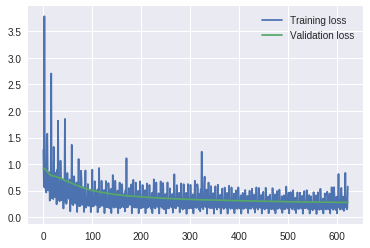

Epoch: 45/100... Step: 628 train_loss: 0.3415... mean_val_loss: 0.2770
Epoch: 46/100... Step: 632 train_loss: 0.1997... mean_val_loss: 0.2770
Epoch: 46/100... Step: 636 train_loss: 0.1429... mean_val_loss: 0.2767
Epoch: 46/100... Step: 640 train_loss: 0.1778... mean_val_loss: 0.2763


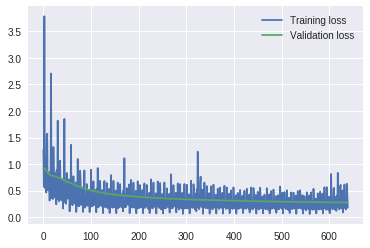

Epoch: 46/100... Step: 644 train_loss: 0.0694... mean_val_loss: 0.2760
Epoch: 47/100... Step: 648 train_loss: 0.1589... mean_val_loss: 0.2757
model saved with 0.27522966038275715 mean_val_loss
Epoch: 47/100... Step: 652 train_loss: 0.5516... mean_val_loss: 0.2752
model saved with 0.2747147446327911 mean_val_loss
Epoch: 47/100... Step: 656 train_loss: 0.1538... mean_val_loss: 0.2747


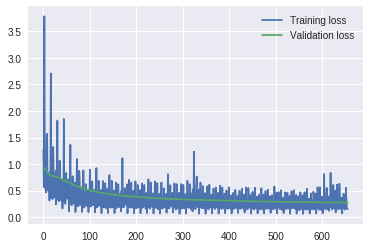

model saved with 0.2742256371812387 mean_val_loss
Epoch: 48/100... Step: 660 train_loss: 0.2064... mean_val_loss: 0.2742
model saved with 0.2738137392394514 mean_val_loss
Epoch: 48/100... Step: 664 train_loss: 0.1433... mean_val_loss: 0.2738
model saved with 0.27359532195137826 mean_val_loss
Epoch: 48/100... Step: 668 train_loss: 0.2043... mean_val_loss: 0.2736
model saved with 0.27330825863117797 mean_val_loss
Epoch: 48/100... Step: 672 train_loss: 0.0770... mean_val_loss: 0.2733


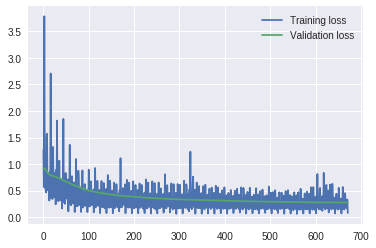

model saved with 0.2728746330817423 mean_val_loss
Epoch: 49/100... Step: 676 train_loss: 0.1539... mean_val_loss: 0.2729
model saved with 0.2724337752744117 mean_val_loss
Epoch: 49/100... Step: 680 train_loss: 0.4393... mean_val_loss: 0.2724
model saved with 0.272091074617939 mean_val_loss
Epoch: 49/100... Step: 684 train_loss: 0.1582... mean_val_loss: 0.2721
model saved with 0.27173315969209166 mean_val_loss
Epoch: 50/100... Step: 688 train_loss: 0.1962... mean_val_loss: 0.2717


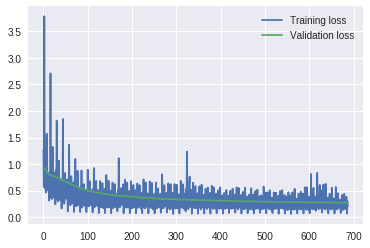

model saved with 0.2713347929502929 mean_val_loss
Epoch: 50/100... Step: 692 train_loss: 0.1345... mean_val_loss: 0.2713
model saved with 0.2709222265262285 mean_val_loss
Epoch: 50/100... Step: 696 train_loss: 0.1832... mean_val_loss: 0.2709
model saved with 0.2705085742686476 mean_val_loss
Epoch: 50/100... Step: 700 train_loss: 0.0682... mean_val_loss: 0.2705
model saved with 0.27010197325778956 mean_val_loss
Epoch: 51/100... Step: 704 train_loss: 0.1520... mean_val_loss: 0.2701


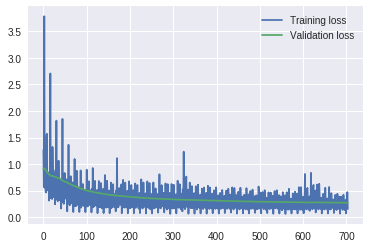

model saved with 0.26984597909353714 mean_val_loss
Epoch: 51/100... Step: 708 train_loss: 0.4673... mean_val_loss: 0.2698
model saved with 0.2696613759650022 mean_val_loss
Epoch: 51/100... Step: 712 train_loss: 0.1400... mean_val_loss: 0.2697
model saved with 0.26938861065320463 mean_val_loss
Epoch: 52/100... Step: 716 train_loss: 0.2081... mean_val_loss: 0.2694
model saved with 0.2689713720180508 mean_val_loss
Epoch: 52/100... Step: 720 train_loss: 0.1525... mean_val_loss: 0.2690


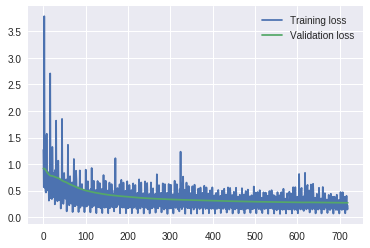

model saved with 0.26850908145678964 mean_val_loss
Epoch: 52/100... Step: 724 train_loss: 0.1646... mean_val_loss: 0.2685
model saved with 0.26811470558539363 mean_val_loss
Epoch: 52/100... Step: 728 train_loss: 0.0644... mean_val_loss: 0.2681
model saved with 0.26779332319834354 mean_val_loss
Epoch: 53/100... Step: 732 train_loss: 0.1366... mean_val_loss: 0.2678
model saved with 0.26751860952936113 mean_val_loss
Epoch: 53/100... Step: 736 train_loss: 0.4075... mean_val_loss: 0.2675


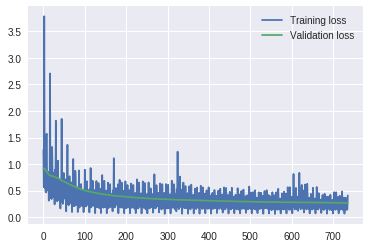

model saved with 0.26719488153183785 mean_val_loss
Epoch: 53/100... Step: 740 train_loss: 0.1620... mean_val_loss: 0.2672
model saved with 0.26685219631600443 mean_val_loss
Epoch: 54/100... Step: 744 train_loss: 0.1599... mean_val_loss: 0.2669
model saved with 0.266527432026989 mean_val_loss
Epoch: 54/100... Step: 748 train_loss: 0.1413... mean_val_loss: 0.2665
model saved with 0.2662255245340156 mean_val_loss
Epoch: 54/100... Step: 752 train_loss: 0.1723... mean_val_loss: 0.2662


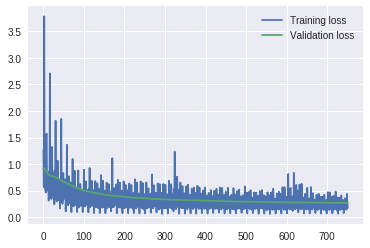

model saved with 0.2659779562659207 mean_val_loss
Epoch: 54/100... Step: 756 train_loss: 0.0603... mean_val_loss: 0.2660
model saved with 0.2656999265137864 mean_val_loss
Epoch: 55/100... Step: 760 train_loss: 0.1459... mean_val_loss: 0.2657
model saved with 0.26540345078851074 mean_val_loss
Epoch: 55/100... Step: 764 train_loss: 0.4109... mean_val_loss: 0.2654
model saved with 0.26519279973581433 mean_val_loss
Epoch: 55/100... Step: 768 train_loss: 0.1304... mean_val_loss: 0.2652


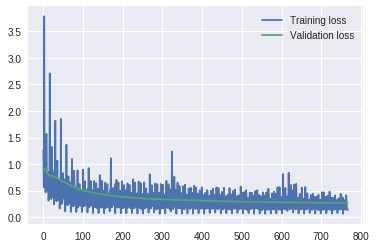

model saved with 0.2650913325490652 mean_val_loss
Epoch: 56/100... Step: 772 train_loss: 0.2008... mean_val_loss: 0.2651
model saved with 0.26475214804090635 mean_val_loss
Epoch: 56/100... Step: 776 train_loss: 0.1364... mean_val_loss: 0.2648
model saved with 0.26431909850679147 mean_val_loss
Epoch: 56/100... Step: 780 train_loss: 0.1621... mean_val_loss: 0.2643
model saved with 0.2638886293624433 mean_val_loss
Epoch: 56/100... Step: 784 train_loss: 0.0713... mean_val_loss: 0.2639


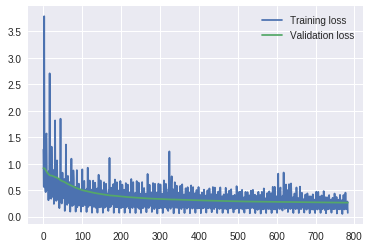

model saved with 0.2635371459430547 mean_val_loss
Epoch: 57/100... Step: 788 train_loss: 0.1424... mean_val_loss: 0.2635
model saved with 0.2635027238666409 mean_val_loss
Epoch: 57/100... Step: 792 train_loss: 0.4903... mean_val_loss: 0.2635
model saved with 0.263286990698558 mean_val_loss
Epoch: 57/100... Step: 796 train_loss: 0.1420... mean_val_loss: 0.2633
model saved with 0.26299299316480756 mean_val_loss
Epoch: 58/100... Step: 800 train_loss: 0.1845... mean_val_loss: 0.2630


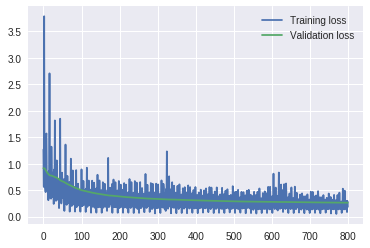

model saved with 0.26291351369234606 mean_val_loss
Epoch: 58/100... Step: 804 train_loss: 0.1398... mean_val_loss: 0.2629
Epoch: 58/100... Step: 808 train_loss: 0.1776... mean_val_loss: 0.2633
Epoch: 58/100... Step: 812 train_loss: 0.0680... mean_val_loss: 0.2637
Epoch: 59/100... Step: 816 train_loss: 0.1481... mean_val_loss: 0.2636


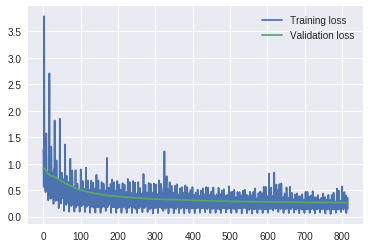

Epoch: 59/100... Step: 820 train_loss: 0.4716... mean_val_loss: 0.2632
Epoch: 59/100... Step: 824 train_loss: 0.1567... mean_val_loss: 0.2629
model saved with 0.26262483016052396 mean_val_loss
Epoch: 60/100... Step: 828 train_loss: 0.2038... mean_val_loss: 0.2626
model saved with 0.2623506937928211 mean_val_loss
Epoch: 60/100... Step: 832 train_loss: 0.1382... mean_val_loss: 0.2624


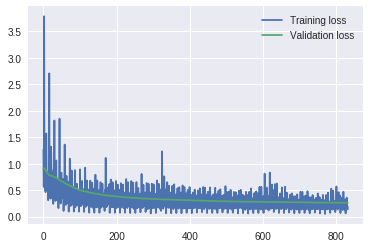

model saved with 0.26206594565660474 mean_val_loss
Epoch: 60/100... Step: 836 train_loss: 0.1472... mean_val_loss: 0.2621
model saved with 0.26170599961742047 mean_val_loss
Epoch: 60/100... Step: 840 train_loss: 0.0609... mean_val_loss: 0.2617
model saved with 0.2614031674525749 mean_val_loss
Epoch: 61/100... Step: 844 train_loss: 0.1387... mean_val_loss: 0.2614
Epoch: 61/100... Step: 848 train_loss: 0.3892... mean_val_loss: 0.2615


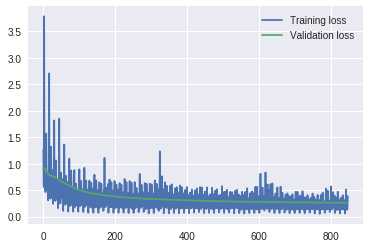

Epoch: 61/100... Step: 852 train_loss: 0.1595... mean_val_loss: 0.2619
Epoch: 62/100... Step: 856 train_loss: 0.1872... mean_val_loss: 0.2622
Epoch: 62/100... Step: 860 train_loss: 0.1293... mean_val_loss: 0.2620
Epoch: 62/100... Step: 864 train_loss: 0.1478... mean_val_loss: 0.2617


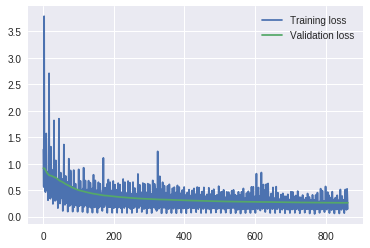

Epoch: 62/100... Step: 868 train_loss: 0.0578... mean_val_loss: 0.2615
model saved with 0.26120451674583034 mean_val_loss
Epoch: 63/100... Step: 872 train_loss: 0.1419... mean_val_loss: 0.2612
model saved with 0.2611363148614424 mean_val_loss
Epoch: 63/100... Step: 876 train_loss: 0.4290... mean_val_loss: 0.2611
model saved with 0.26101168720898305 mean_val_loss
Epoch: 63/100... Step: 880 train_loss: 0.1335... mean_val_loss: 0.2610


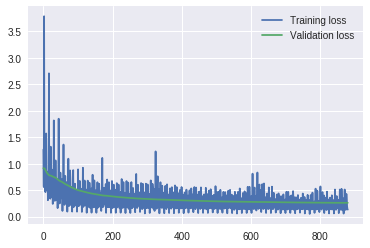

model saved with 0.26083096544936774 mean_val_loss
Epoch: 64/100... Step: 884 train_loss: 0.1956... mean_val_loss: 0.2608
model saved with 0.2606976854841451 mean_val_loss
Epoch: 64/100... Step: 888 train_loss: 0.1260... mean_val_loss: 0.2607
model saved with 0.2606757213507733 mean_val_loss
Epoch: 64/100... Step: 892 train_loss: 0.1459... mean_val_loss: 0.2607
Epoch: 64/100... Step: 896 train_loss: 0.0586... mean_val_loss: 0.2608


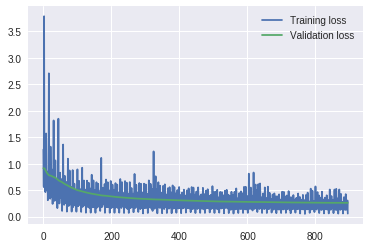

Epoch: 65/100... Step: 900 train_loss: 0.1394... mean_val_loss: 0.2608
model saved with 0.26060205147873644 mean_val_loss
Epoch: 65/100... Step: 904 train_loss: 0.4643... mean_val_loss: 0.2606
model saved with 0.26037640746124907 mean_val_loss
Epoch: 65/100... Step: 908 train_loss: 0.1605... mean_val_loss: 0.2604
model saved with 0.2601501779393865 mean_val_loss
Epoch: 66/100... Step: 912 train_loss: 0.1853... mean_val_loss: 0.2602


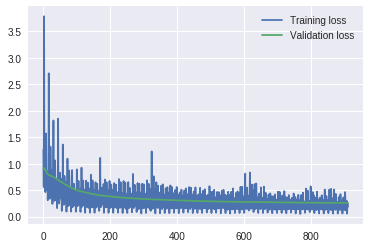

model saved with 0.26004880270208985 mean_val_loss
Epoch: 66/100... Step: 916 train_loss: 0.1247... mean_val_loss: 0.2600
Epoch: 66/100... Step: 920 train_loss: 0.1853... mean_val_loss: 0.2601
model saved with 0.2600025480161562 mean_val_loss
Epoch: 66/100... Step: 924 train_loss: 0.0671... mean_val_loss: 0.2600
model saved with 0.25993140759990263 mean_val_loss
Epoch: 67/100... Step: 928 train_loss: 0.1306... mean_val_loss: 0.2599


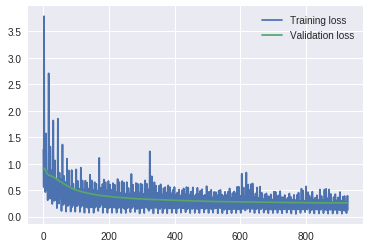

Epoch: 67/100... Step: 932 train_loss: 0.3697... mean_val_loss: 0.2601
Epoch: 67/100... Step: 936 train_loss: 0.1319... mean_val_loss: 0.2604
Epoch: 68/100... Step: 940 train_loss: 0.1835... mean_val_loss: 0.2608
Epoch: 68/100... Step: 944 train_loss: 0.1208... mean_val_loss: 0.2608


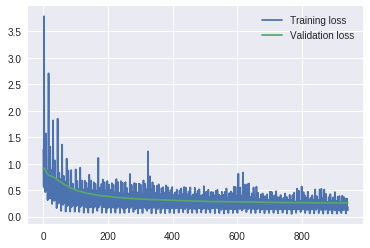

Epoch: 68/100... Step: 948 train_loss: 0.1371... mean_val_loss: 0.2605
Epoch: 68/100... Step: 952 train_loss: 0.0513... mean_val_loss: 0.2603
Epoch: 69/100... Step: 956 train_loss: 0.1353... mean_val_loss: 0.2601
Epoch: 69/100... Step: 960 train_loss: 0.3646... mean_val_loss: 0.2601


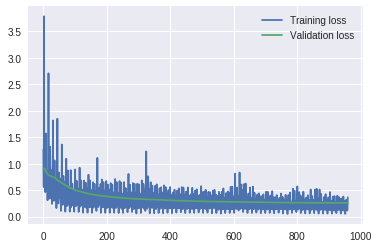

Epoch: 69/100... Step: 964 train_loss: 0.1236... mean_val_loss: 0.2601
Epoch: 70/100... Step: 968 train_loss: 0.1672... mean_val_loss: 0.2602
Epoch: 70/100... Step: 972 train_loss: 0.1313... mean_val_loss: 0.2601
Epoch: 70/100... Step: 976 train_loss: 0.1379... mean_val_loss: 0.2600


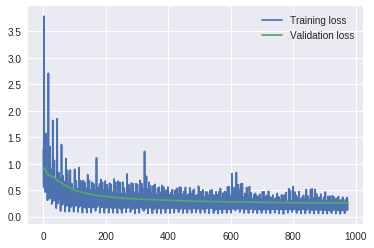

model saved with 0.2599247594991205 mean_val_loss
Epoch: 70/100... Step: 980 train_loss: 0.0557... mean_val_loss: 0.2599
model saved with 0.25987807830523063 mean_val_loss
Epoch: 71/100... Step: 984 train_loss: 0.1230... mean_val_loss: 0.2599
model saved with 0.25977381939815003 mean_val_loss
Epoch: 71/100... Step: 988 train_loss: 0.3755... mean_val_loss: 0.2598
model saved with 0.2596886873943731 mean_val_loss
Epoch: 71/100... Step: 992 train_loss: 0.1499... mean_val_loss: 0.2597


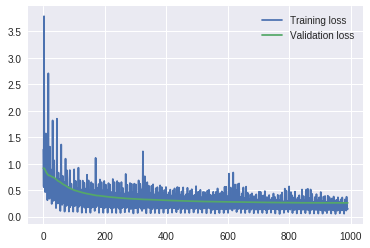

model saved with 0.25965292797046136 mean_val_loss
Epoch: 72/100... Step: 996 train_loss: 0.1639... mean_val_loss: 0.2597
Epoch: 72/100... Step: 1000 train_loss: 0.1220... mean_val_loss: 0.2597
Epoch: 72/100... Step: 1004 train_loss: 0.1230... mean_val_loss: 0.2598
Epoch: 72/100... Step: 1008 train_loss: 0.0560... mean_val_loss: 0.2599


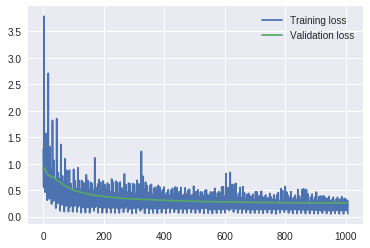

Epoch: 73/100... Step: 1012 train_loss: 0.1378... mean_val_loss: 0.2599
Epoch: 73/100... Step: 1016 train_loss: 0.3077... mean_val_loss: 0.2600
Epoch: 73/100... Step: 1020 train_loss: 0.1248... mean_val_loss: 0.2603
Epoch: 74/100... Step: 1024 train_loss: 0.1527... mean_val_loss: 0.2606


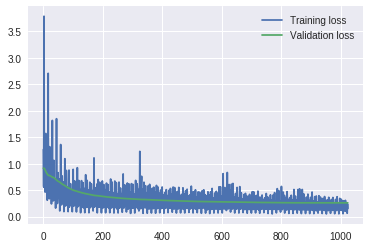

Epoch: 74/100... Step: 1028 train_loss: 0.1202... mean_val_loss: 0.2607
Epoch: 74/100... Step: 1032 train_loss: 0.1070... mean_val_loss: 0.2606
Epoch: 74/100... Step: 1036 train_loss: 0.0606... mean_val_loss: 0.2606
Epoch: 75/100... Step: 1040 train_loss: 0.1288... mean_val_loss: 0.2606


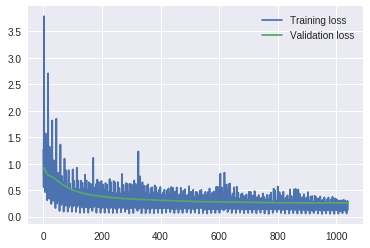

Epoch: 75/100... Step: 1044 train_loss: 0.3512... mean_val_loss: 0.2607
Epoch: 75/100... Step: 1048 train_loss: 0.1085... mean_val_loss: 0.2608
Epoch: 76/100... Step: 1052 train_loss: 0.1269... mean_val_loss: 0.2609
Epoch: 76/100... Step: 1056 train_loss: 0.1196... mean_val_loss: 0.2610


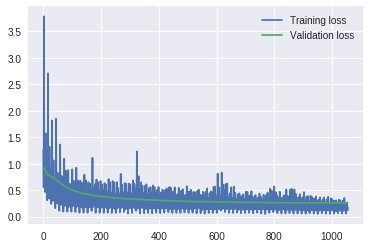

Epoch: 76/100... Step: 1060 train_loss: 0.1089... mean_val_loss: 0.2611
Epoch: 76/100... Step: 1064 train_loss: 0.0650... mean_val_loss: 0.2613
Epoch: 77/100... Step: 1068 train_loss: 0.1249... mean_val_loss: 0.2614
Epoch: 77/100... Step: 1072 train_loss: 0.3744... mean_val_loss: 0.2614


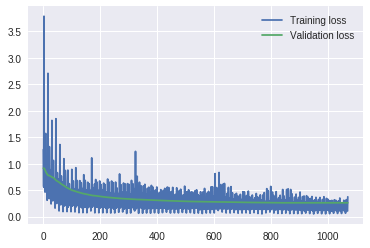

Epoch: 77/100... Step: 1076 train_loss: 0.1265... mean_val_loss: 0.2614
Epoch: 78/100... Step: 1080 train_loss: 0.1518... mean_val_loss: 0.2614
Epoch: 78/100... Step: 1084 train_loss: 0.1089... mean_val_loss: 0.2615
Epoch: 78/100... Step: 1088 train_loss: 0.1350... mean_val_loss: 0.2616


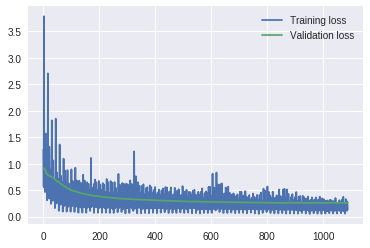

Epoch: 78/100... Step: 1092 train_loss: 0.0797... mean_val_loss: 0.2616
Epoch: 79/100... Step: 1096 train_loss: 0.1286... mean_val_loss: 0.2616
Epoch: 79/100... Step: 1100 train_loss: 0.3076... mean_val_loss: 0.2618
Epoch: 79/100... Step: 1104 train_loss: 0.1092... mean_val_loss: 0.2621


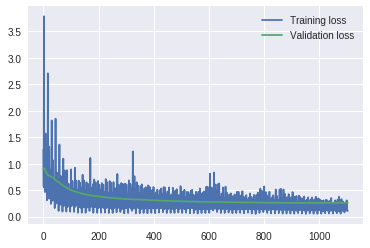

Epoch: 80/100... Step: 1108 train_loss: 0.1348... mean_val_loss: 0.2625
Epoch: 80/100... Step: 1112 train_loss: 0.1145... mean_val_loss: 0.2626
Epoch: 80/100... Step: 1116 train_loss: 0.1103... mean_val_loss: 0.2625
Epoch: 80/100... Step: 1120 train_loss: 0.0570... mean_val_loss: 0.2624


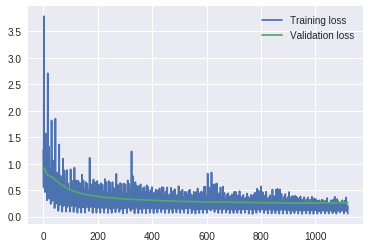

Epoch: 81/100... Step: 1124 train_loss: 0.1300... mean_val_loss: 0.2623
Epoch: 81/100... Step: 1128 train_loss: 0.2978... mean_val_loss: 0.2625
Epoch: 81/100... Step: 1132 train_loss: 0.0855... mean_val_loss: 0.2626
Epoch: 82/100... Step: 1136 train_loss: 0.1362... mean_val_loss: 0.2627


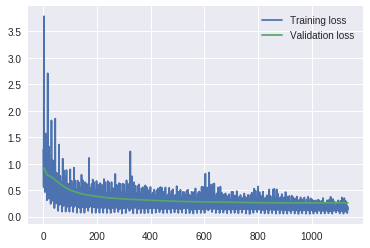

Epoch: 82/100... Step: 1140 train_loss: 0.0998... mean_val_loss: 0.2628
Epoch: 82/100... Step: 1144 train_loss: 0.1229... mean_val_loss: 0.2629
Epoch: 82/100... Step: 1148 train_loss: 0.0613... mean_val_loss: 0.2631
Epoch: 83/100... Step: 1152 train_loss: 0.1309... mean_val_loss: 0.2633


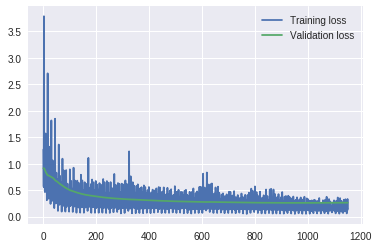

Epoch: 83/100... Step: 1156 train_loss: 0.2856... mean_val_loss: 0.2633
Epoch: 83/100... Step: 1160 train_loss: 0.1533... mean_val_loss: 0.2633
Epoch: 84/100... Step: 1164 train_loss: 0.1490... mean_val_loss: 0.2634
Epoch: 84/100... Step: 1168 train_loss: 0.1173... mean_val_loss: 0.2636


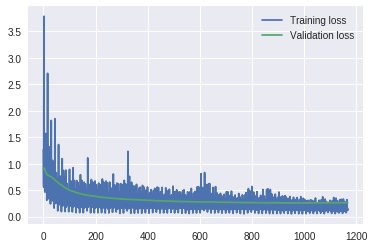

Epoch: 84/100... Step: 1172 train_loss: 0.1440... mean_val_loss: 0.2639
Epoch: 84/100... Step: 1176 train_loss: 0.0679... mean_val_loss: 0.2642
Epoch: 85/100... Step: 1180 train_loss: 0.1234... mean_val_loss: 0.2644
Epoch: 85/100... Step: 1184 train_loss: 0.3208... mean_val_loss: 0.2646


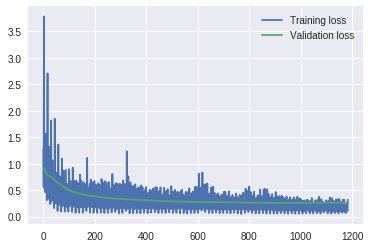

Epoch: 85/100... Step: 1188 train_loss: 0.1185... mean_val_loss: 0.2648
Epoch: 86/100... Step: 1192 train_loss: 0.1249... mean_val_loss: 0.2651
Epoch: 86/100... Step: 1196 train_loss: 0.1010... mean_val_loss: 0.2652
Epoch: 86/100... Step: 1200 train_loss: 0.0864... mean_val_loss: 0.2653


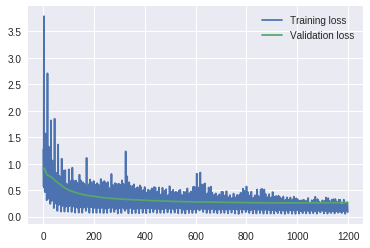

Epoch: 86/100... Step: 1204 train_loss: 0.0491... mean_val_loss: 0.2654
Epoch: 87/100... Step: 1208 train_loss: 0.1068... mean_val_loss: 0.2654
Epoch: 87/100... Step: 1212 train_loss: 0.2678... mean_val_loss: 0.2656
Epoch: 87/100... Step: 1216 train_loss: 0.1092... mean_val_loss: 0.2657


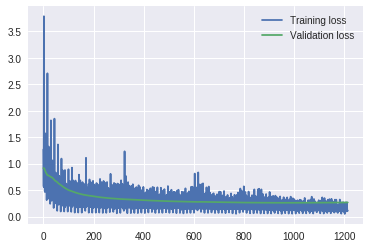

Epoch: 88/100... Step: 1220 train_loss: 0.1402... mean_val_loss: 0.2659
Epoch: 88/100... Step: 1224 train_loss: 0.1080... mean_val_loss: 0.2660
Epoch: 88/100... Step: 1228 train_loss: 0.1015... mean_val_loss: 0.2662
Epoch: 88/100... Step: 1232 train_loss: 0.0566... mean_val_loss: 0.2666


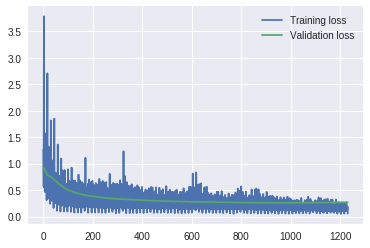

Epoch: 89/100... Step: 1236 train_loss: 0.1262... mean_val_loss: 0.2669
Epoch: 89/100... Step: 1240 train_loss: 0.3037... mean_val_loss: 0.2670
Epoch: 89/100... Step: 1244 train_loss: 0.0972... mean_val_loss: 0.2670
Epoch: 90/100... Step: 1248 train_loss: 0.1078... mean_val_loss: 0.2670


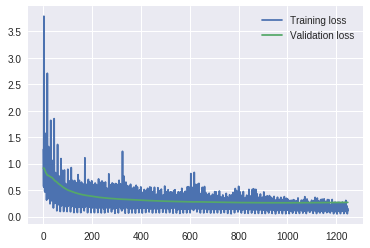

Epoch: 90/100... Step: 1252 train_loss: 0.1004... mean_val_loss: 0.2672
Epoch: 90/100... Step: 1256 train_loss: 0.0925... mean_val_loss: 0.2675
Epoch: 90/100... Step: 1260 train_loss: 0.0560... mean_val_loss: 0.2677
Epoch: 91/100... Step: 1264 train_loss: 0.1135... mean_val_loss: 0.2679


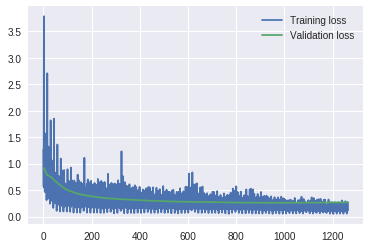

Epoch: 91/100... Step: 1268 train_loss: 0.2890... mean_val_loss: 0.2681
Epoch: 91/100... Step: 1272 train_loss: 0.1177... mean_val_loss: 0.2683
Epoch: 92/100... Step: 1276 train_loss: 0.1253... mean_val_loss: 0.2684
Epoch: 92/100... Step: 1280 train_loss: 0.0905... mean_val_loss: 0.2684


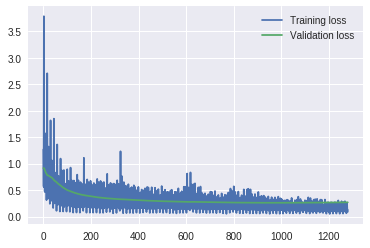

Epoch: 92/100... Step: 1284 train_loss: 0.0994... mean_val_loss: 0.2684
Epoch: 92/100... Step: 1288 train_loss: 0.0515... mean_val_loss: 0.2684
Epoch: 93/100... Step: 1292 train_loss: 0.1048... mean_val_loss: 0.2685
Epoch: 93/100... Step: 1296 train_loss: 0.2400... mean_val_loss: 0.2687


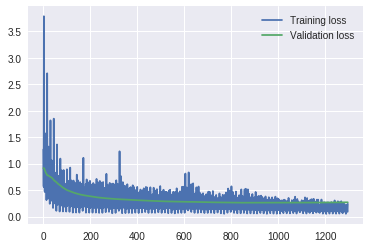

Epoch: 93/100... Step: 1300 train_loss: 0.0876... mean_val_loss: 0.2687
Epoch: 94/100... Step: 1304 train_loss: 0.1395... mean_val_loss: 0.2688
Epoch: 94/100... Step: 1308 train_loss: 0.0957... mean_val_loss: 0.2688
Epoch: 94/100... Step: 1312 train_loss: 0.0728... mean_val_loss: 0.2689


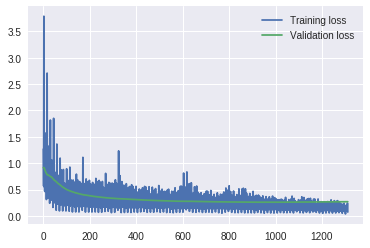

Epoch: 94/100... Step: 1316 train_loss: 0.0618... mean_val_loss: 0.2691
Epoch: 95/100... Step: 1320 train_loss: 0.1076... mean_val_loss: 0.2692
Epoch: 95/100... Step: 1324 train_loss: 0.2760... mean_val_loss: 0.2693
Epoch: 95/100... Step: 1328 train_loss: 0.1104... mean_val_loss: 0.2693


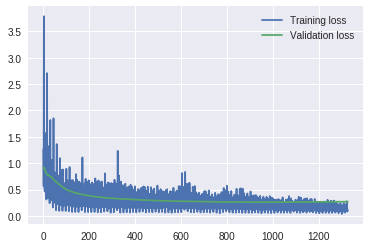

Epoch: 96/100... Step: 1332 train_loss: 0.1365... mean_val_loss: 0.2693
Epoch: 96/100... Step: 1336 train_loss: 0.0935... mean_val_loss: 0.2694
Epoch: 96/100... Step: 1340 train_loss: 0.0894... mean_val_loss: 0.2695
Epoch: 96/100... Step: 1344 train_loss: 0.0499... mean_val_loss: 0.2696


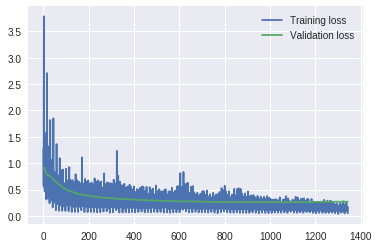

Epoch: 97/100... Step: 1348 train_loss: 0.1000... mean_val_loss: 0.2697
Epoch: 97/100... Step: 1352 train_loss: 0.2658... mean_val_loss: 0.2697
Epoch: 97/100... Step: 1356 train_loss: 0.0867... mean_val_loss: 0.2697
Epoch: 98/100... Step: 1360 train_loss: 0.1178... mean_val_loss: 0.2698


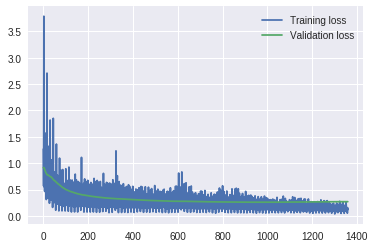

Epoch: 98/100... Step: 1364 train_loss: 0.0876... mean_val_loss: 0.2699
Epoch: 98/100... Step: 1368 train_loss: 0.0884... mean_val_loss: 0.2699
Epoch: 98/100... Step: 1372 train_loss: 0.0522... mean_val_loss: 0.2700
Epoch: 99/100... Step: 1376 train_loss: 0.0899... mean_val_loss: 0.2700


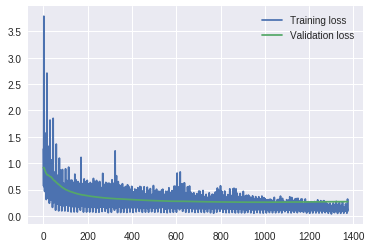

Epoch: 99/100... Step: 1380 train_loss: 0.2825... mean_val_loss: 0.2703
Epoch: 99/100... Step: 1384 train_loss: 0.0996... mean_val_loss: 0.2706
Epoch: 100/100... Step: 1388 train_loss: 0.1113... mean_val_loss: 0.2710
Epoch: 100/100... Step: 1392 train_loss: 0.0927... mean_val_loss: 0.2710


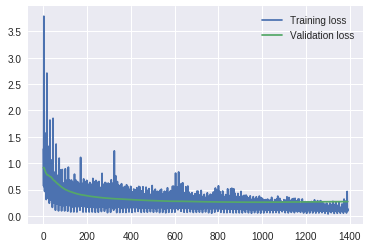

Epoch: 100/100... Step: 1396 train_loss: 0.0887... mean_val_loss: 0.2709
Epoch: 100/100... Step: 1400 train_loss: 0.0518... mean_val_loss: 0.2708


In [10]:
# train the model
cp_name='cp_withtimeperiod.pth'
batch_size = 5
seq_length = 30
n_epochs = 100 # start smaller if you are just testing initial behavior
pmod.train( net, train_data, valid_data, epochs=n_epochs, 
            batch_size=batch_size, seq_length=seq_length, lr=0.001, 
            checkpoint_name=cp_name, train_on_gpu=train_on_gpu)

In [0]:
# load back best model
with open(cp_name, 'rb') as f:
    checkpoint = torch.load(f)
  
net_best = pmod.instantiate_model(checkpoint['input_size'], checkpoint['output_size'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'], train_on_gpu=train_on_gpu)
net_best.load_state_dict(checkpoint['state_dict'])
if(train_on_gpu):
  net_best.cuda()

Use the model with test_data to forecast the first day pollution (day0) and the second day pollution (day1). For the forecast of the second day pollution we use our own forecast of first day pollution.

In [12]:
# check test data
# model to evaluation mode
net_best.eval()
test_losses_MSE = [[], []]
target_list = [[], []]
forecast_list = [[], []]
# during test we simulate the implementation of the deployed usage:
batch_size = 1
seq_length = 1

criterionMSE = nn.MSELoss()

counter = 0
# we will examine the model forecast for the next day where the
# pollution is unknown and for the they after that
# we implement two data-getter for that, one for the first forecast day
# and an other for the next forecast day
batches_day0 = pmod.get_batches(test_data, batch_size, seq_length)
batches_day1 = pmod.get_batches(test_data, batch_size, seq_length)
next(batches_day1)

# data for first forecast day
for inputs_day0, targets_day0 in batches_day0:
    counter+=1
    # break before batches_day1 runs out
    if counter >= len(test_data):
        break
    # data for second forecast day    
    inputs_day1, targets_day1 = next(batches_day1)
    if(train_on_gpu):
      inputs_day0, targets_day0 = inputs_day0.cuda(), targets_day0.cuda()
      inputs_day1, targets_day1 = inputs_day1.cuda(), targets_day1.cuda()

    # calculate forecast for day0
    test_h = net.init_hidden(batch_size)
    output_day0, test_h = net_best(inputs_day0, test_h)
    test_loss_MSE_day0 = criterionMSE(output_day0, targets_day0.view(batch_size*seq_length,-1))
    test_losses_MSE[0].append(test_loss_MSE_day0.item())
    target_list[0].append(targets_day0.item())
    forecast_list[0].append(output_day0.item())

    # need to clone tensor, without this the modification of tensor would affect other data as well
    inputs_day1.data = inputs_day1.clone()
    # we don't change the weather parameters for inputs_day1, because that is our weather forecast,
    # but we change the last number, because that is our pollution forecast from day0
    # our beforday pollution in day1 is the pollution forecast of day0
    inputs_day1[0][0][-1] = output_day0.item()
    # calculate forecast for the day1
    test_h = net.init_hidden(batch_size)
    output_day1, test_h = net_best(inputs_day1, test_h)
    test_loss_MSE_day1 = criterionMSE(output_day1, targets_day1.view(batch_size*seq_length,-1))
    test_losses_MSE[1].append(test_loss_MSE_day1.item())
    target_list[1].append(targets_day1.item())
    forecast_list[1].append(output_day1.item())

print( "test losses MSE for day0: {:.4f}".format(np.mean(test_losses_MSE[0])))
print( "test losses MSE for day1: {:.4f}".format(np.mean(test_losses_MSE[1])))

test losses MSE for day0: 0.3315
test losses MSE for day1: 0.4738


To examine the forecast performance we convert back our data to the original form. This way we get back the μg/m3 concentration numbers. 

In [0]:
# renormalize data to get back the pm10 concentrations
forecast_concentration_day0 = [i * label_std + label_mean for i in forecast_list[0]]
target_concentration_day0 = [i * label_std + label_mean for i in target_list[0]]
abs_error_day0 = [np.abs(a - b) for a, b in zip(forecast_concentration_day0, target_concentration_day0)]

forecast_concentration_day1 = [i * label_std + label_mean for i in forecast_list[1]]
target_concentration_day1 = [i * label_std + label_mean for i in target_list[1]]
abs_error_day1 = [np.abs(a - b) for a, b in zip(forecast_concentration_day1, target_concentration_day1)]

The most simple forecast is if we say that something tomorrow will be the same as something today. We hope that our model is better than that. First calculat the errors for this 'noforecast' forecast, only for day0.

In [14]:
abs_error_day0_noforecast = [np.abs(a - b) for a, b in zip(target_concentration_day1, target_concentration_day0)]
print("ERRORS OF NO FORECAST - we except the same as yesterday")
print(f"Mean Abs Error no forecast: {np.mean(abs_error_day0_noforecast)} μg/m3")
print(f"Median Abs Error no forecast: {np.median(abs_error_day0_noforecast)} μg/m3")
print(f"Max Abs Error no forecast: {np.max(abs_error_day0_noforecast)} μg/m3")

ERRORS OF NO FORECAST - we except the same as yesterday
Mean Abs Error no forecast: 10.083333255536143 μg/m3
Median Abs Error no forecast: 7.99999993649581 μg/m3
Max Abs Error no forecast: 66.00000165692495 μg/m3


Now we calculate our forecasts by the model for day0 and the next day1.

In [15]:
# error stat day0s:
print("ERRORS OF DAY0 FORECAST")
print(f"Mean Abs Error day0: {np.mean(abs_error_day0)} μg/m3")
print(f"Median Abs Error day0: {np.median(abs_error_day0)} μg/m3")
print(f"Max Abs Error day0: {np.max(abs_error_day0)} μg/m3")
print("MSE for day0: {:.4f}".format(np.mean(test_losses_MSE[0])))

# error stats day1:
print("ERRORS OF DAY1 FORECAST")
print(f"Mean Abs Error day1: {np.mean(abs_error_day1)} μg/m3")
print(f"Median Abs Error day1: {np.median(abs_error_day1)} μg/m3")
print(f"Max Abs Error day1: {np.max(abs_error_day1)} μg/m3")
print("MSE for day1: {:.4f}".format(np.mean(test_losses_MSE[1])))

ERRORS OF DAY0 FORECAST
Mean Abs Error day0: 7.958320740775569 μg/m3
Median Abs Error day0: 6.018590054939379 μg/m3
Max Abs Error day0: 37.15804507585902 μg/m3
MSE for day0: 0.3315
ERRORS OF DAY1 FORECAST
Mean Abs Error day1: 9.67298321906899 μg/m3
Median Abs Error day1: 7.734916492941064 μg/m3
Max Abs Error day1: 49.38425509207627 μg/m3
MSE for day1: 0.4738


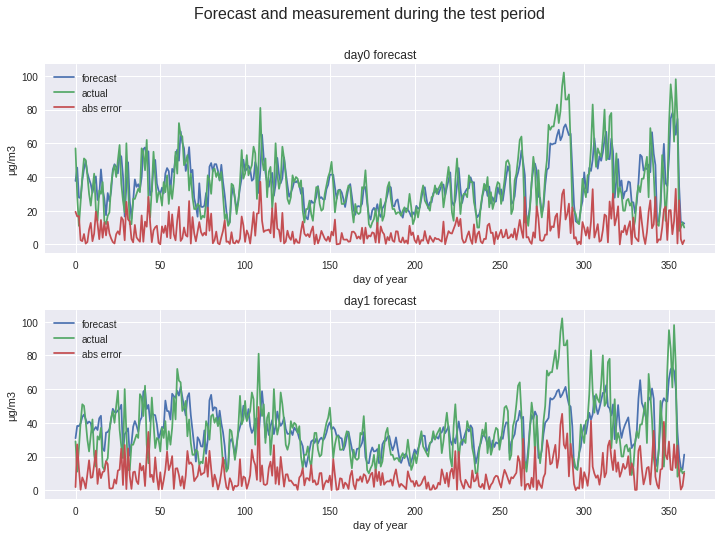

In [16]:
fig, axs = plt.subplots(2, 1, figsize=(12, 8))
axs[0].plot(forecast_concentration_day0, label='forecast')
axs[0].plot(target_concentration_day0, label='actual')
axs[0].plot(abs_error_day0, label='abs error')
axs[0].set_title('day0 forecast')
axs[0].set_xlabel('day of year')
axs[0].set_ylabel('μg/m3')
axs[0].legend()
fig.suptitle('Forecast and measurement during the test period', fontsize=16)

axs[1].plot(forecast_concentration_day1, label='forecast')
axs[1].plot(target_concentration_day1, label='actual')
axs[1].plot(abs_error_day1, label='abs error')
axs[1].set_title('day1 forecast')
axs[1].set_xlabel('day of year')
axs[1].set_ylabel('μg/m3')
axs[1].legend()

fig.subplots_adjust(hspace=0.3)

plt.show()